In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [2]:
import ResNetModel as RNM

# this is my modification of ResNetOptimalModel.py
# I modified the main ResNet50Regression() function to take the following args:

# def ResNet50Regression(input_dim=1, output_dim=1, width=16, n_layers=2, bn=False):
#    """Instantiates the ResNet50 architecture.
#    # Arguments
#         input_dim {1}: X data will have shape, X.shape = (N, intput_dim)
#         output_dim {1}: y data will have shape, y.shape = (N, output_dim)
#         width {16}: width of each layer
#         n_hidden_layers {3}: number of hidden ResNet blocks
#         bn {False}: bool. Use batch normalisation or not after each layer

In [3]:
import numpy as np
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# helper function to scale data

In [4]:
def scale_x_y(x, y):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_x.fit(x)
    x = scaler_x.transform(x)
    scaler_y.fit(y)
    y = scaler_y.transform(y)

    return x, y

In [5]:
def sort_by_first(x, y):
    Xy = np.array(list(zip(x, y)))
    x_sorted, y_sorted = Xy[np.argsort(Xy[:, 0])].T
    return x_sorted, y_sorted

In [57]:
def plot_prediction_comparison(X, y, models, labels):
    
    # data has been shuffled in train_test_split
    # so plotting a line plot is messy.
    # we fix this by sorting the data
    X, y = sort_by_first(X[:,0], y[:,0])
    
    
    yhats = []
    for model in models:
        yhats.append(model.predict(X)[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(X, y, label='data')
    for i, yhat in enumerate(yhats):
        plt.plot(X, yhat, label=labels[i])
    plt.legend()
    plt.title("prediction")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(14, 6))
    for i, yhat in enumerate(yhats):
        plt.plot(X, y - yhat, label=labels[i])
    plt.title("residuals")
    plt.legend()
    plt.show()
    plt.close()
    
    
    plt.figure(figsize=(14, 6))
    for i, yhat in enumerate(yhats):
        plt.plot(X, np.abs(y - yhat), label=labels[i])
    plt.yscale('log')
    plt.axhline(0.1, c='k', ls='-')
    plt.axhline(0.01, c='k', ls='--')
    plt.legend()
    plt.title("Absolute difference (log scale)")
    plt.show()
    plt.close()

# generate fake data

In [7]:
def gen_data(npts=1000):
    x = np.linspace(0, 1, npts)
    y = x + x ** 2 * np.sin(x * 2 * np.pi / 0.5)
    return x.reshape(-1, 1), y.reshape(-1, 1)

In [8]:
# gen data
X, y = gen_data(npts=1000)

# scale data
X, y = scale_x_y(X, y)

# split and shuffle data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# check shapes
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(750, 1)
(250, 1)
(750, 1)
(250, 1)


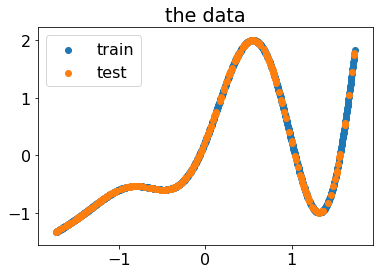

In [9]:
plt.figure()
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.title('the data')
plt.legend()

# example 1 - 'Plain' Deep Neural Network with same width and depth as ResNetOptimal

In [10]:
# the ResNetOptimalModel uses:
# a width of 16 units in each layer and
# a depth of 28 layers
# I believe that is:
#   1 input layer
#   26 hidden layers
#   1 output layer

In [43]:
def build_model_example_1(units=16, n_hidden_layers=26):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units, input_dim=1, activation='relu'))
    for i in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.summary()
    return model

In [44]:
def compile_model(model, learning_rate=1e-3):
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    
    return model

In [49]:
model1 = build_model_example_1()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 16)                32        
_________________________________________________________________
dense_125 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_126 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_127 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_128 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_129 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_130 (Dense)            (None, 16)               

In [50]:
model1 = compile_model(model1)

In [51]:
callbacks = None

In [52]:
starttime = datetime.datetime.now()
history1 = model1.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=callbacks,
    validation_split=0.2)
endtime = datetime.datetime.now()

print('The time cost: ')
print(endtime - starttime)

Train on 600 samples, validate on 150 samples
Epoch 1/500
600/600 - 1s - loss: 0.9779 - mse: 0.9779 - val_loss: 0.9591 - val_mse: 0.9591
Epoch 2/500
600/600 - 0s - loss: 0.9775 - mse: 0.9775 - val_loss: 0.9583 - val_mse: 0.9583
Epoch 3/500
600/600 - 0s - loss: 0.9667 - mse: 0.9667 - val_loss: 0.8841 - val_mse: 0.8841
Epoch 4/500
600/600 - 0s - loss: 0.7642 - mse: 0.7642 - val_loss: 0.6209 - val_mse: 0.6209
Epoch 5/500
600/600 - 0s - loss: 0.6420 - mse: 0.6420 - val_loss: 0.5271 - val_mse: 0.5271
Epoch 6/500
600/600 - 0s - loss: 0.5562 - mse: 0.5562 - val_loss: 0.4528 - val_mse: 0.4528
Epoch 7/500
600/600 - 0s - loss: 0.5154 - mse: 0.5154 - val_loss: 0.4357 - val_mse: 0.4357
Epoch 8/500
600/600 - 0s - loss: 0.5118 - mse: 0.5118 - val_loss: 0.4360 - val_mse: 0.4360
Epoch 9/500
600/600 - 0s - loss: 0.5103 - mse: 0.5103 - val_loss: 0.4357 - val_mse: 0.4357
Epoch 10/500
600/600 - 0s - loss: 0.5103 - mse: 0.5103 - val_loss: 0.4369 - val_mse: 0.4369
Epoch 11/500
600/600 - 0s - loss: 0.5101 - 

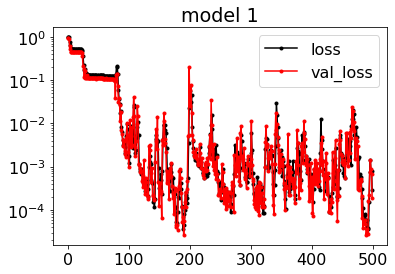

In [53]:
plt.figure()
plt.plot(history1.history['loss'], 'k.-', label='loss')
plt.plot(history1.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model 1')
plt.legend()

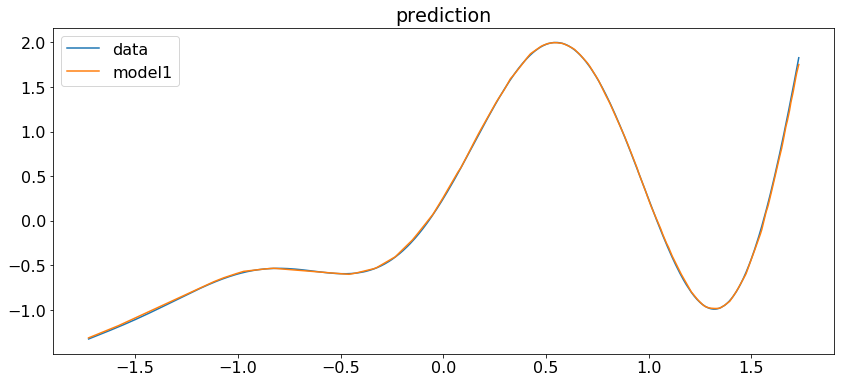

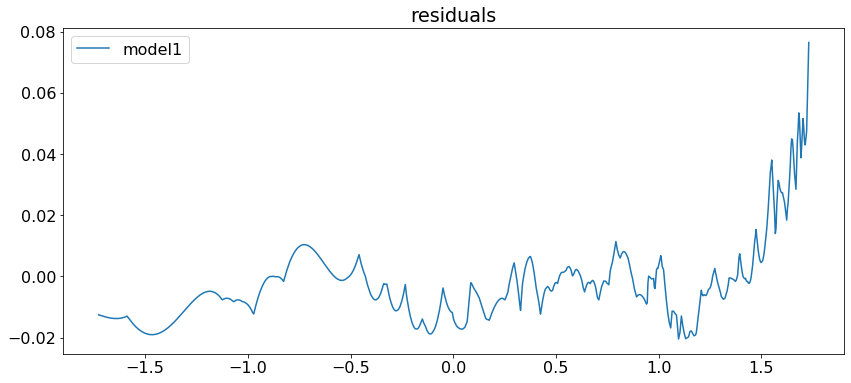

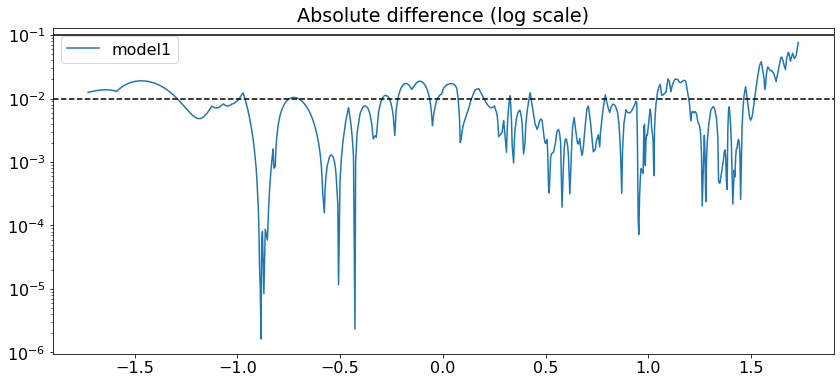

In [60]:
plot_prediction_comparison(X_train, y_train, [model1], ['model1'])

# example 1a - 'Plain' Deep Neural Network with fewer layers

In [19]:
model1a = build_model_example_1(units=16, n_hidden_layers=4)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_32 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
____________________________________________________

In [20]:
model1a = compile_model(model1a)

In [21]:
callbacks = None

In [22]:
starttime = datetime.datetime.now()
history1a = model1a.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=callbacks,
    validation_split=0.2)
endtime = datetime.datetime.now()

print('The time cost: ')
print(endtime - starttime)

Train on 600 samples, validate on 150 samples
Epoch 1/500
600/600 - 0s - loss: 0.9292 - mse: 0.9292 - val_loss: 0.8534 - val_mse: 0.8534
Epoch 2/500
600/600 - 0s - loss: 0.8449 - mse: 0.8449 - val_loss: 0.7468 - val_mse: 0.7468
Epoch 3/500
600/600 - 0s - loss: 0.7443 - mse: 0.7443 - val_loss: 0.6254 - val_mse: 0.6254
Epoch 4/500
600/600 - 0s - loss: 0.6390 - mse: 0.6390 - val_loss: 0.5209 - val_mse: 0.5209
Epoch 5/500
600/600 - 0s - loss: 0.5749 - mse: 0.5749 - val_loss: 0.4817 - val_mse: 0.4817
Epoch 6/500
600/600 - 0s - loss: 0.5337 - mse: 0.5337 - val_loss: 0.4413 - val_mse: 0.4413
Epoch 7/500
600/600 - 0s - loss: 0.4797 - mse: 0.4797 - val_loss: 0.3847 - val_mse: 0.3847
Epoch 8/500
600/600 - 0s - loss: 0.4088 - mse: 0.4088 - val_loss: 0.3214 - val_mse: 0.3214
Epoch 9/500
600/600 - 0s - loss: 0.3215 - mse: 0.3215 - val_loss: 0.2423 - val_mse: 0.2423
Epoch 10/500
600/600 - 0s - loss: 0.2427 - mse: 0.2427 - val_loss: 0.1821 - val_mse: 0.1821
Epoch 11/500
600/600 - 0s - loss: 0.1901 - 

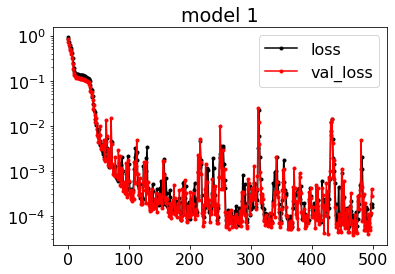

In [23]:
plt.figure()
plt.plot(history1a.history['loss'], 'k.-', label='loss')
plt.plot(history1a.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model 1a')
plt.legend()

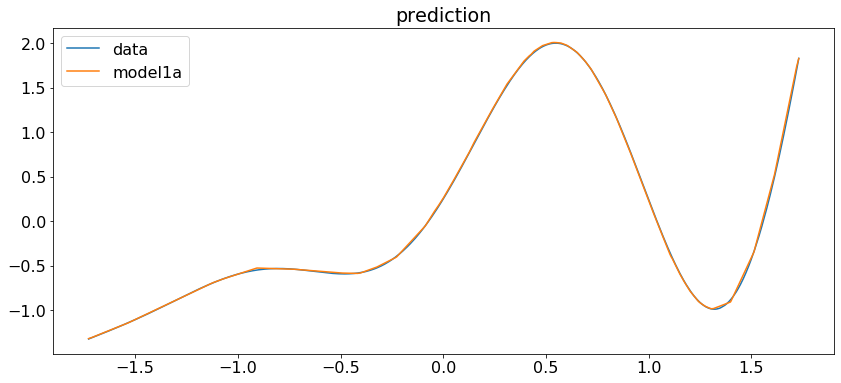

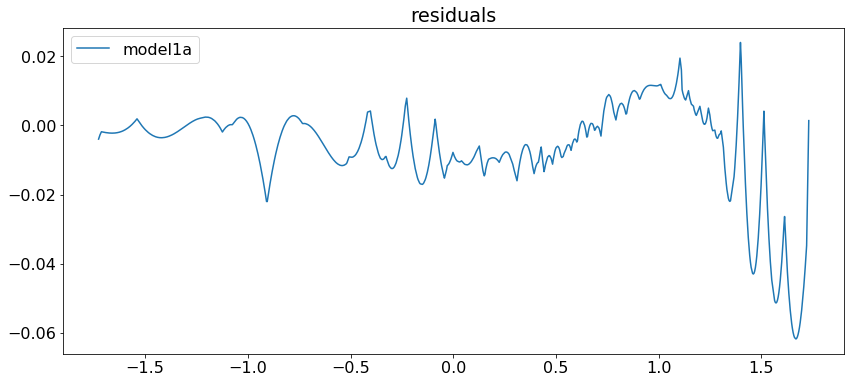

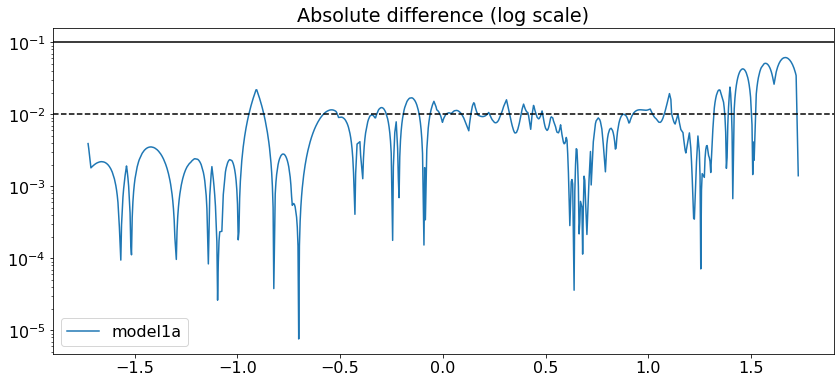

In [61]:
plot_prediction_comparison(X_train, y_train, [model1a], ['model1a'])

# example 2 - ResNet with batch normalisation

In [25]:
def build_resnet_model(width=16, n_hiddlen_layers=2, bn=True):
    model = RNM.ResNet50Regression(input_dim=1, output_dim=1, width=width, n_layers=n_hiddlen_layers, bn=bn)
    model.summary()
    return model

In [26]:
model2 = build_resnet_model(bn=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 16)           32          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16)           64          dense_34[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 16)           0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
model2 = compile_model(model2)

In [28]:
callbacks = None

In [29]:
starttime = datetime.datetime.now()
history2 = model2.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=callbacks,
    validation_split=0.2)
endtime = datetime.datetime.now()

print('The time cost: ')
print(endtime - starttime)

Train on 600 samples, validate on 150 samples
Epoch 1/500
600/600 - 5s - loss: 1.1257 - mse: 1.1257 - val_loss: 0.9664 - val_mse: 0.9664
Epoch 2/500
600/600 - 0s - loss: 0.9423 - mse: 0.9423 - val_loss: 0.9737 - val_mse: 0.9737
Epoch 3/500
600/600 - 0s - loss: 0.8166 - mse: 0.8166 - val_loss: 0.9419 - val_mse: 0.9419
Epoch 4/500
600/600 - 0s - loss: 0.7125 - mse: 0.7125 - val_loss: 0.9105 - val_mse: 0.9105
Epoch 5/500
600/600 - 0s - loss: 0.6975 - mse: 0.6975 - val_loss: 0.8862 - val_mse: 0.8862
Epoch 6/500
600/600 - 0s - loss: 0.5462 - mse: 0.5462 - val_loss: 0.8788 - val_mse: 0.8788
Epoch 7/500
600/600 - 0s - loss: 0.5258 - mse: 0.5258 - val_loss: 0.8848 - val_mse: 0.8848
Epoch 8/500
600/600 - 0s - loss: 0.4479 - mse: 0.4479 - val_loss: 0.8847 - val_mse: 0.8847
Epoch 9/500
600/600 - 0s - loss: 0.4298 - mse: 0.4298 - val_loss: 0.8416 - val_mse: 0.8416
Epoch 10/500
600/600 - 0s - loss: 0.3652 - mse: 0.3652 - val_loss: 0.7985 - val_mse: 0.7985
Epoch 11/500
600/600 - 0s - loss: 0.3061 - 

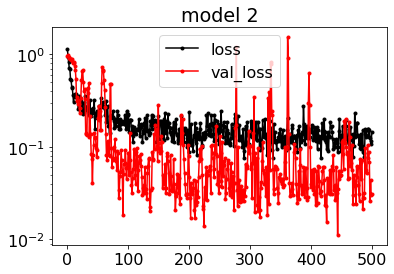

In [30]:
plt.figure()
plt.plot(history2.history['loss'], 'k.-', label='loss')
plt.plot(history2.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model 2')
plt.legend()

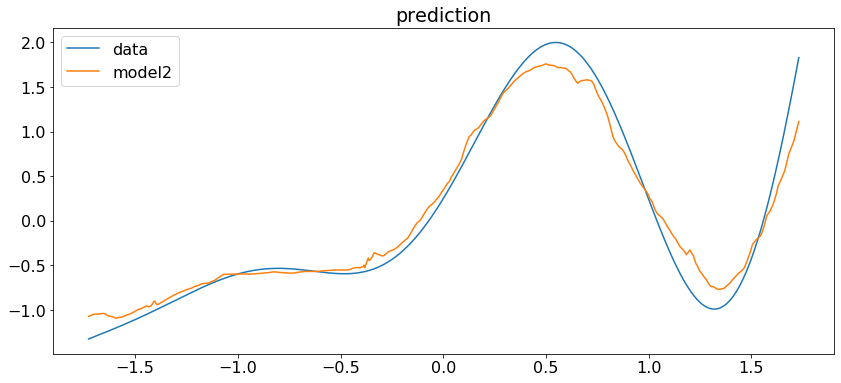

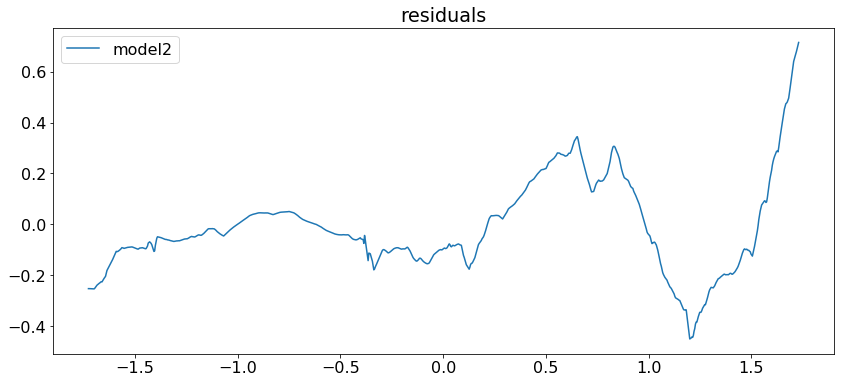

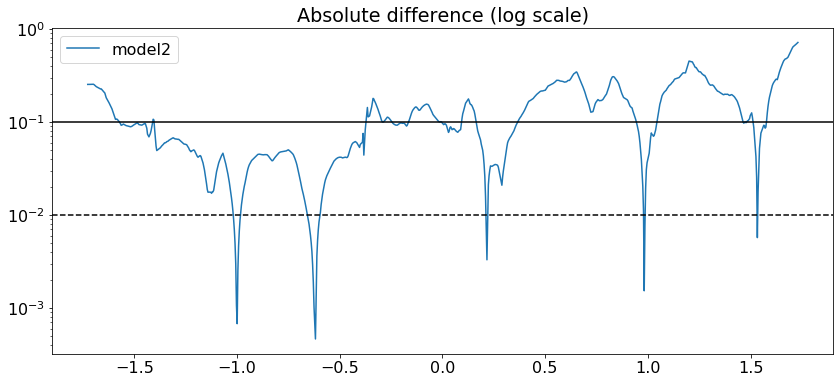

In [62]:
plot_prediction_comparison(X_train, y_train, [model2], ['model2'])

# example 3 - ResNet without batch normalisation

In [32]:
model3 = build_resnet_model(bn=False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 16)           32          input_2[0][0]                    
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 16)           0           dense_65[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 16)           272         activation_27[0][0]              
____________________________________________________________________________________________

In [33]:
model3 = compile_model(model3)

In [34]:
callbacks = None

In [35]:
starttime = datetime.datetime.now()
history3 = model3.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=callbacks,
    validation_split=0.2)
endtime = datetime.datetime.now()

print('The time cost: ')
print(endtime - starttime)

Train on 600 samples, validate on 150 samples
Epoch 1/500
600/600 - 1s - loss: 0.4078 - mse: 0.4078 - val_loss: 0.8628 - val_mse: 0.8628
Epoch 2/500
600/600 - 0s - loss: 0.2448 - mse: 0.2448 - val_loss: 0.8497 - val_mse: 0.8497
Epoch 3/500
600/600 - 0s - loss: 0.1182 - mse: 0.1182 - val_loss: 0.8209 - val_mse: 0.8209
Epoch 4/500
600/600 - 0s - loss: 0.0796 - mse: 0.0796 - val_loss: 0.8157 - val_mse: 0.8157
Epoch 5/500
600/600 - 0s - loss: 0.0799 - mse: 0.0799 - val_loss: 0.8144 - val_mse: 0.8144
Epoch 6/500
600/600 - 0s - loss: 0.0714 - mse: 0.0714 - val_loss: 0.7891 - val_mse: 0.7891
Epoch 7/500
600/600 - 0s - loss: 0.0335 - mse: 0.0335 - val_loss: 0.7665 - val_mse: 0.7665
Epoch 8/500
600/600 - 0s - loss: 0.0367 - mse: 0.0367 - val_loss: 0.7552 - val_mse: 0.7552
Epoch 9/500
600/600 - 0s - loss: 0.0474 - mse: 0.0474 - val_loss: 0.7417 - val_mse: 0.7417
Epoch 10/500
600/600 - 0s - loss: 0.0409 - mse: 0.0409 - val_loss: 0.7249 - val_mse: 0.7249
Epoch 11/500
600/600 - 0s - loss: 0.0454 - 

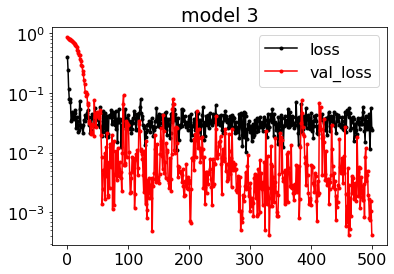

In [36]:
plt.figure()
plt.plot(history3.history['loss'], 'k.-', label='loss')
plt.plot(history3.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model 3')
plt.legend()

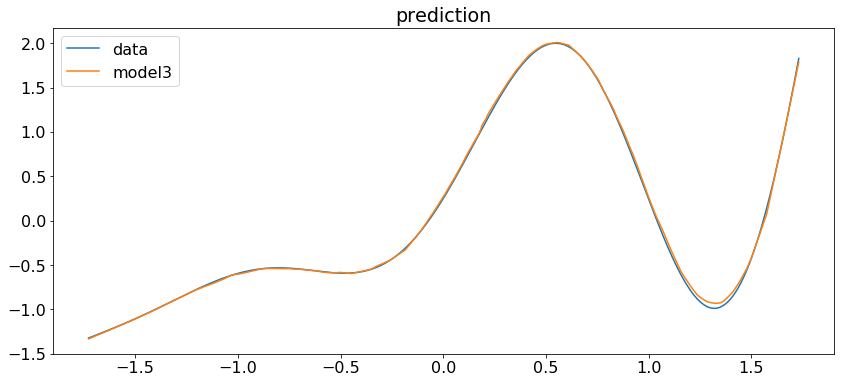

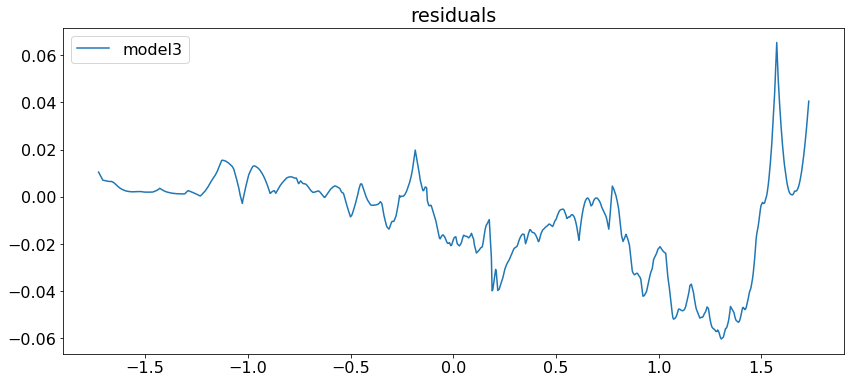

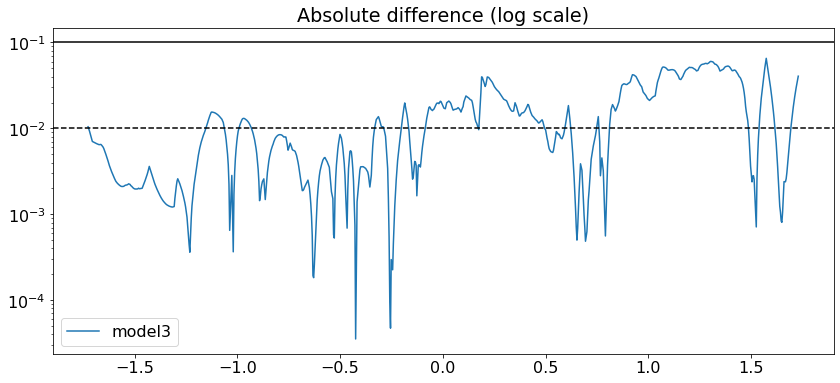

In [63]:
plot_prediction_comparison(X_train, y_train, [model3], ['model3'])

# comparison 

reminder on the models


model1 ('m1'):
This should be the same as ResNetOptimalModel but without skip connections or BatchNormalization.
So this is a 'plain' deep feedforward network:
26 hidden layers
16 units in width

model1a ('m1a'):
same as model1 but with fewer hidden layers.
Uses 4 hidden layers

model2 ('m2'):
This should be the same as ResNetOptimalModel

model3 ('m3'):
Same as model2 but without the BatchNormalization layers

I find that:

    1. ResNet with BatchNoramlisation performs worst for some reason
    2. ResNet without BatchNorm is next worst
    3. Model1 and Model1a perform similarly but with a bit caveat that
    it is difficult to train model1 due to the large depth of the network.
    I found that it is essentially 'random' as to whether or not the Model1
    network would actually learn anything or if it would not learn anything at all.
    
Regardless I find that the ResNets do train everytime dispite being very deep networks.
There must be a way to improve their accuracy though.

I think for my work I am aiming for a worst case residual error of about 1e-2 

In [38]:
labels=['m1', 'm1a', 'm2', 'm3']

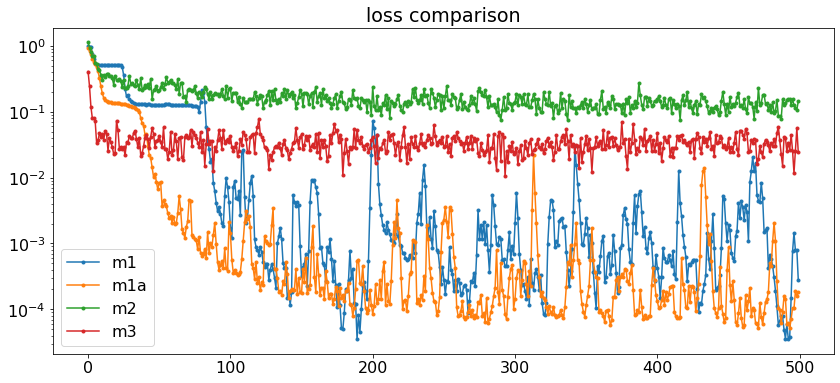

In [56]:
plt.figure(figsize=(14, 6))
for i, h in enumerate([history1, history1a, history2, history3]):
    plt.plot(h.history['loss'], '.-', label=labels[i])
plt.yscale('log')
plt.title('loss comparison')
plt.legend()

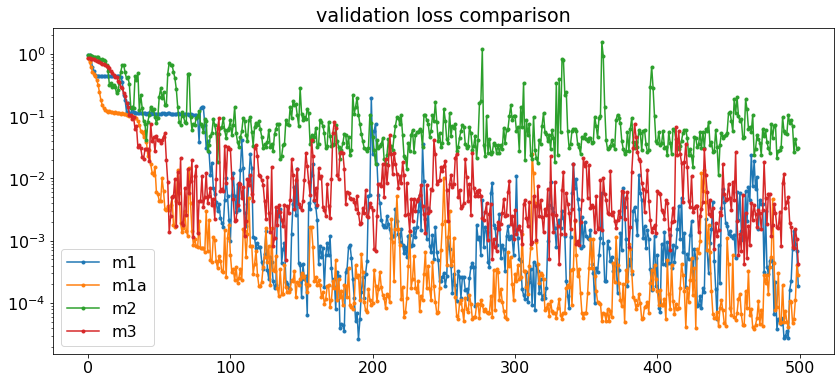

In [55]:
plt.figure(figsize=(14, 6))
for i, h in enumerate([history1, history1a, history2, history3]):
    plt.plot(h.history['val_loss'], '.-', label=labels[i])
plt.yscale('log')
plt.title('validation loss comparison')
plt.legend()

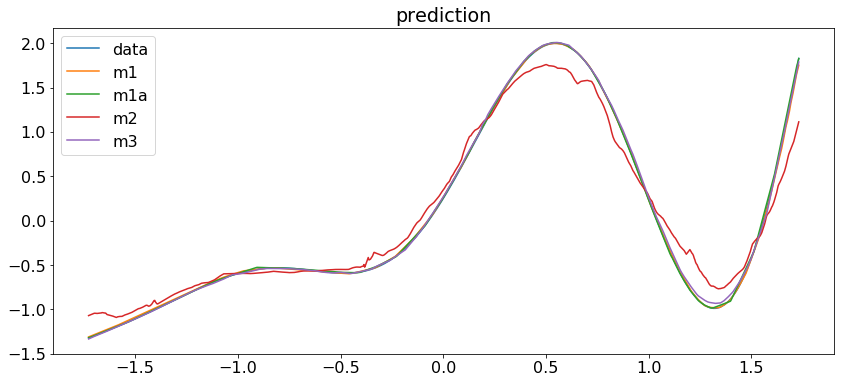

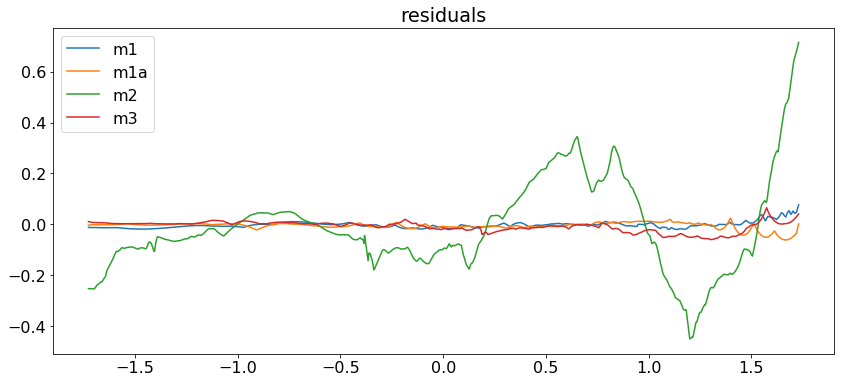

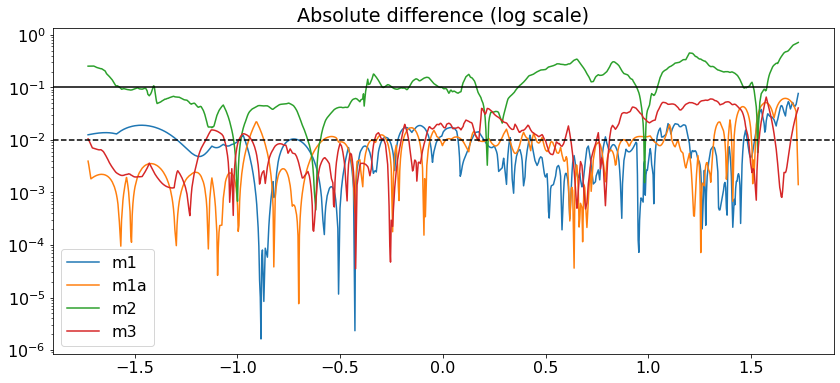

In [58]:
plot_prediction_comparison(X_train, y_train, models=[model1, model1a, model2, model3], labels=labels)